In [1]:
try:
    import tensorflow as tf
    from keras.models import Sequential, save_model, load_model
    from keras.layers import Dense, LSTM, Input, Dropout
    from keras.callbacks import EarlyStopping
    from padasip.filters import FilterRLS
    from sklearn.multioutput import MultiOutputRegressor
    from lightgbm import LGBMRegressor
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta, timezone
    import json
    import pickle
    import os
    import sys
    import argparse
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from DB_Utils import select_model_for_forecast, load_artifact_from_storage, store_forecasts, fetch_data, get_all_feeder_ids, fetch_feeder_data
    from supabase import create_client, Client
    import traceback
    import plotly.express as px
    from dotenv import load_dotenv, find_dotenv
    import seaborn as sns
    import matplotlib.pyplot as plt

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # Or '2' or '3'

    KERAS_AVAILABLE = True
    PADASIP_AVAILABLE = True

    np.set_printoptions(suppress=True)

    load_dotenv()
    print("Env file found at location: ", find_dotenv())

except ImportError:
    print("TensorFlow/Keras not found. Keras models cannot be trained/saved natively.")
    KERAS_AVAILABLE = False
    # Define dummy classes if needed for type checking, though not strictly necessary here
    Sequential, save_model, load_model = object, lambda x, y: None, lambda x: None
    Dense, LSTM, Input, Dropout, EarlyStopping = object, object, object, object, object

    print("padasip not found. RLS filters cannot be loaded/used.")
    PADASIP_AVAILABLE = False
    FilterRLS = object


# --- Configuration & Constants --- (Same as before)
SUPABASE_URL = os.environ.get("SUPABASE_URL")
SUPABASE_KEY = os.environ.get("SUPABASE_SECRET_KEY")
if not SUPABASE_URL or not SUPABASE_KEY or "YOUR_SUPABASE_URL" in SUPABASE_URL:
    print("Error: SUPABASE_URL and SUPABASE_KEY environment variables must be set.")
    # sys.exit(1)

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
DATA_SCHEMA = "data"
ML_SCHEMA = "ml"
STORAGE_BUCKET = "models"
FEEDER_ID_TO_TRAIN = 1
SCENARIO = "Day"  # Example
MODEL_VERSION = "v1.1_Is_Weekend"  # Updated version
TRAIN_START_DATE = "2024-01-01 00:00:00+00"
TRAIN_END_DATE = "2024-05-31 23:59:59+00"
VALIDATION_START_DATE = "2024-06-01 00:00:00+00"
VALIDATION_END_DATE = "2024-06-30 23:59:59+00"
DAY_HOURS = list(range(6, 20 + 1))
NIGHT_HOURS = list(range(0, 6)) + list(range(21, 24))
script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
TEMP_DIR = os.path.join(script_dir, "tmp")

Env file found at location:  h:\My Drive\Barbados_Forecasting_Tool_Final\.env
Env file found at location:  h:\My Drive\Barbados_Forecasting_Tool_Final\.env


In [2]:
feeder_ids = get_all_feeder_ids(supabase)
combined_feeders = []

for feeder_id in feeder_ids:
    feeder_data = fetch_feeder_data(feeder_id, "2024-01-01", "2024-06-30")
    if feeder_data is not None:
        feeder_data["feeder_id"] = feeder_id  # Add feeder_id to the data
        combined_feeders.append(feeder_data)
        
combined_feeders_df = pd.concat(combined_feeders, axis=0)
# combined_feeders_df["Timestamp"] = pd.to_datetime(combined_feeders_df["Timestamp"])
combined_feeders_df

Fetching list of Feeder IDs...
Found 12 feeders: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Fetching data for Feeder 1 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 2 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 3 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 4 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 5 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 6 from 2024-01-01 to 2024-06-30...
Fetched 4368 records.
Fetching data for Feeder 7 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 8 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 9 from 2024-01-01 to 2024-06-30...
Fetched 2544 records.
Fetching data for Feeder 10 from 2024-01-01 to 2024-06-30...
Fetched 2544 records.
Fetching data for Feeder 11 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetchin

,Net_Load_Demand,feeder_id
Timestamp,,
2024-01-01 00:00:00+00:00,5707.900000,1
2024-01-01 01:00:00+00:00,5609.932857,1
2024-01-01 02:00:00+00:00,5569.238889,1
2024-01-01 03:00:00+00:00,5369.317500,1
2024-01-01 04:00:00+00:00,5233.525000,1
...,...,...
2024-06-30 19:00:00+00:00,619.500000,12
2024-06-30 20:00:00+00:00,726.000000,12
2024-06-30 21:00:00+00:00,729.000000,12


Text(0, 0.5, 'Value')

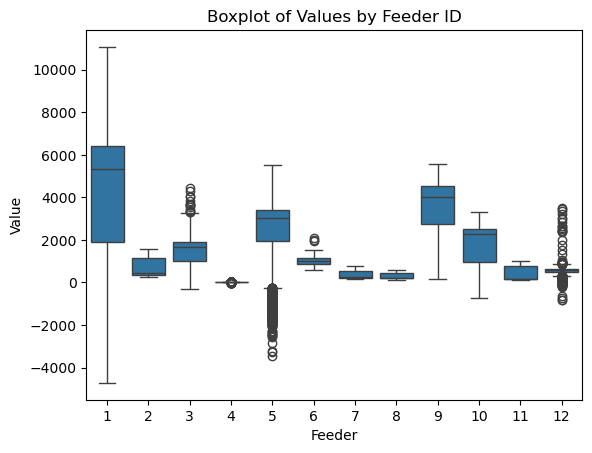

In [10]:
sns.boxplot(data=combined_feeders_df, x="feeder_id", y="Net_Load_Demand")
plt.title("Boxplot of Values by Feeder ID")
plt.xlabel("Feeder")
plt.ylabel("Value")
# plt.xticks(rotation=45)
# plt.tight_layout()


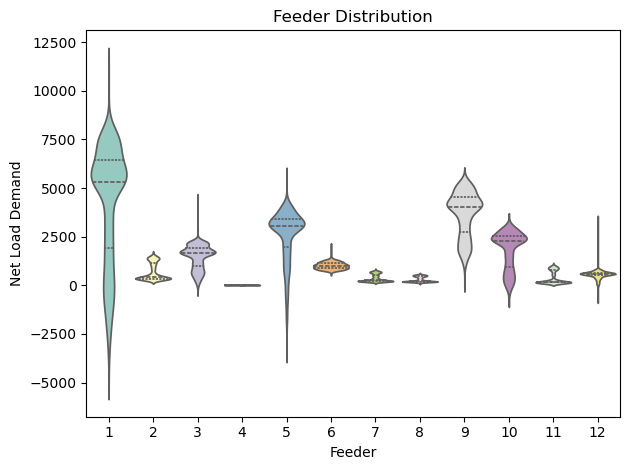

In [15]:
sns.violinplot(x='feeder_id', y='Net_Load_Demand', data=combined_feeders_df, palette='Set3', hue='feeder_id', split=False, inner="quartile", legend=False)
plt.title('Feeder Distribution')
plt.xlabel("Feeder")
plt.ylabel("Net Load Demand")
plt.tight_layout()
plt.show()

In [17]:
feeder_ids = get_all_feeder_ids(supabase)
combined_feeders_weather = []

for feeder_id in feeder_ids:
    feeder_data = fetch_data(feeder_id, "2024-01-01", "2024-06-30")
    if feeder_data is not None:
        combined_feeders_weather.append(feeder_data)
        
combined_feeders_weather_df = pd.concat(combined_feeders_weather, axis=0)
# combined_feeders_weather_df["Timestamp"] = pd.to_datetime(combined_feeders_weather_df["Timestamp"])
combined_feeders_weather_df

Fetching list of Feeder IDs...
Found 12 feeders: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Fetching data for Feeder 1 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 2 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 3 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 4 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 5 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 6 from 2024-01-01 to 2024-06-30...
Fetched 4368 records.
Fetching data for Feeder 7 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 8 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetching data for Feeder 9 from 2024-01-01 to 2024-06-30...
Fetched 2544 records.
Fetching data for Feeder 10 from 2024-01-01 to 2024-06-30...
Fetched 2544 records.
Fetching data for Feeder 11 from 2024-01-01 to 2024-06-30...
Fetched 4320 records.
Fetchin

,Net_Load_Demand,Feeder_ID,Temperature_Historic,Temperature_Forecast,Shortwave_Radiation_Historic,Shortwave_Radiation_Forecast,Cloud_Cover_Historic,Cloud_Cover_Forecast
Timestamp,,,,,,,,
2024-01-01 00:00:00+00:00,5707.900000,1,23.902500,24.977499,0,0,71,35
2024-01-01 01:00:00+00:00,5609.932857,1,23.752500,24.977499,0,0,91,34
2024-01-01 02:00:00+00:00,5569.238889,1,23.852500,24.977499,0,0,94,34
2024-01-01 03:00:00+00:00,5369.317500,1,23.552500,24.977499,0,0,100,46
2024-01-01 04:00:00+00:00,5233.525000,1,23.352500,24.927500,0,0,98,50
...,...,...,...,...,...,...,...,...
2024-06-30 19:00:00+00:00,619.500000,12,26.182499,27.557501,7,7,100,100
2024-06-30 20:00:00+00:00,726.000000,12,25.482500,27.257500,0,0,100,100
2024-06-30 21:00:00+00:00,729.000000,12,25.682499,27.107500,0,0,100,100


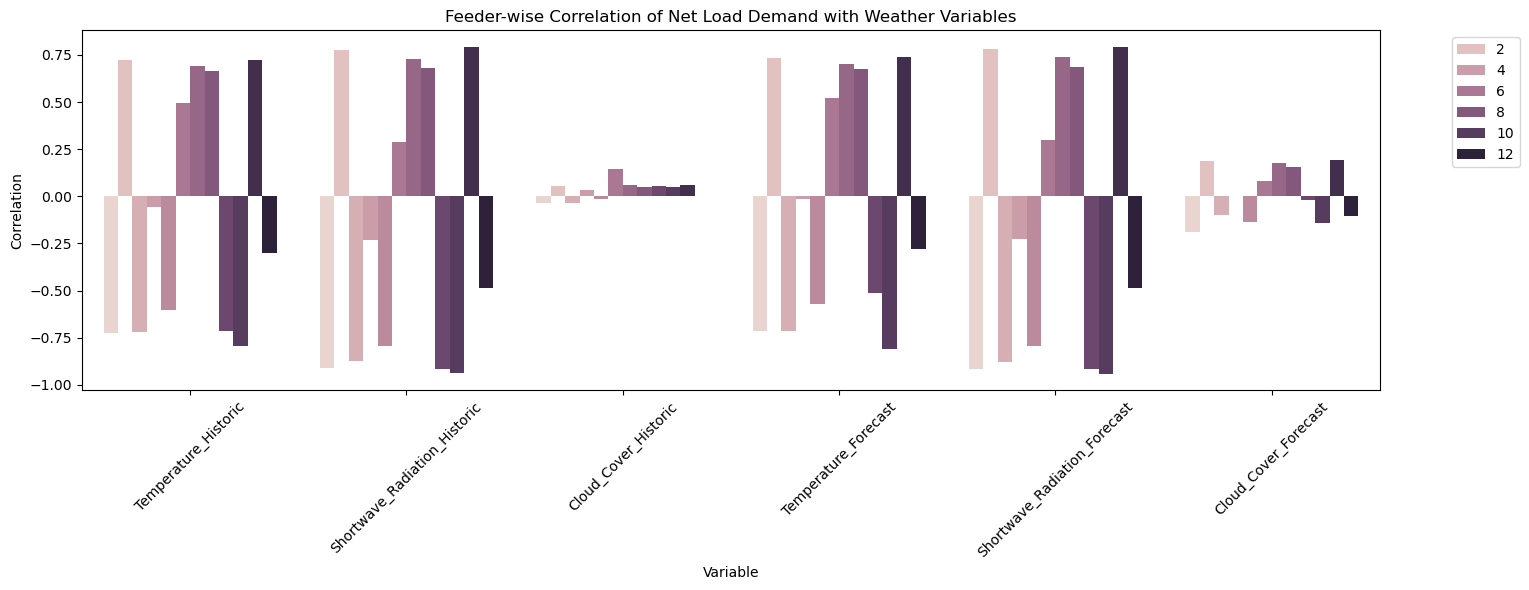

In [31]:
feeder_corrs = []
weather_cols = [
    "Temperature_Historic",
    "Shortwave_Radiation_Historic",
    "Cloud_Cover_Historic",
    "Temperature_Forecast",
    "Shortwave_Radiation_Forecast",
    "Cloud_Cover_Forecast",
]

for feeder_id in combined_feeders_weather_df["Feeder_ID"].unique():
    feeder_df = combined_feeders_weather_df[combined_feeders_weather_df["Feeder_ID"] == feeder_id]
    corrs = feeder_df.corr()["Net_Load_Demand"][weather_cols]
    for var in weather_cols:
        feeder_corrs.append({"Feeder_ID": feeder_id, "Variable": var, "Correlation": corrs[var]})

corr_df = pd.DataFrame(feeder_corrs)

plt.figure(figsize=(14, 6))
sns.barplot(x="Variable", y="Correlation", hue="Feeder_ID", data=corr_df)
plt.title("Feeder-wise Correlation of Net Load Demand with Weather Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

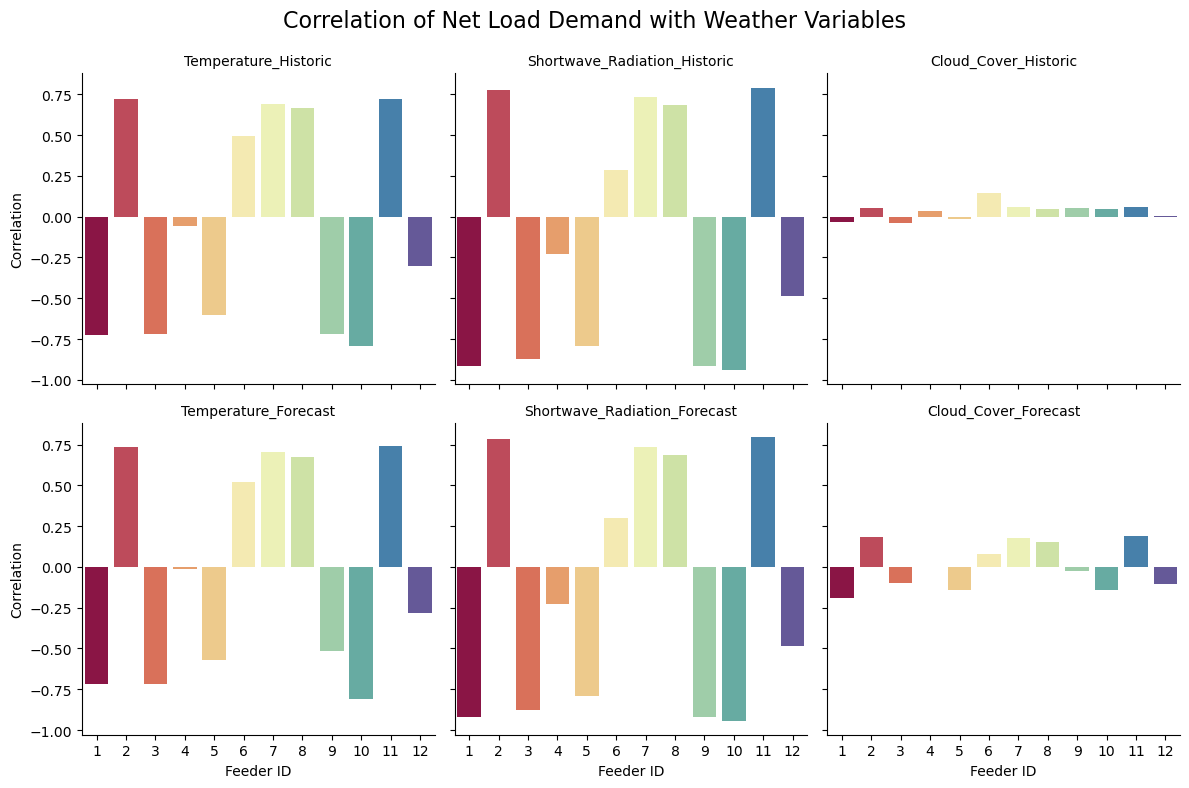

In [38]:
g = sns.FacetGrid(corr_df, col="Variable", col_wrap=3, sharey=True, height=4)
g.map_dataframe(sns.barplot, x="Feeder_ID", y="Correlation", hue='Feeder_ID', palette="Spectral")
g.set_titles("{col_name}")
g.set_axis_labels("Feeder ID", "Correlation")
g.fig.suptitle("Correlation of Net Load Demand with Weather Variables", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)
plt.show()


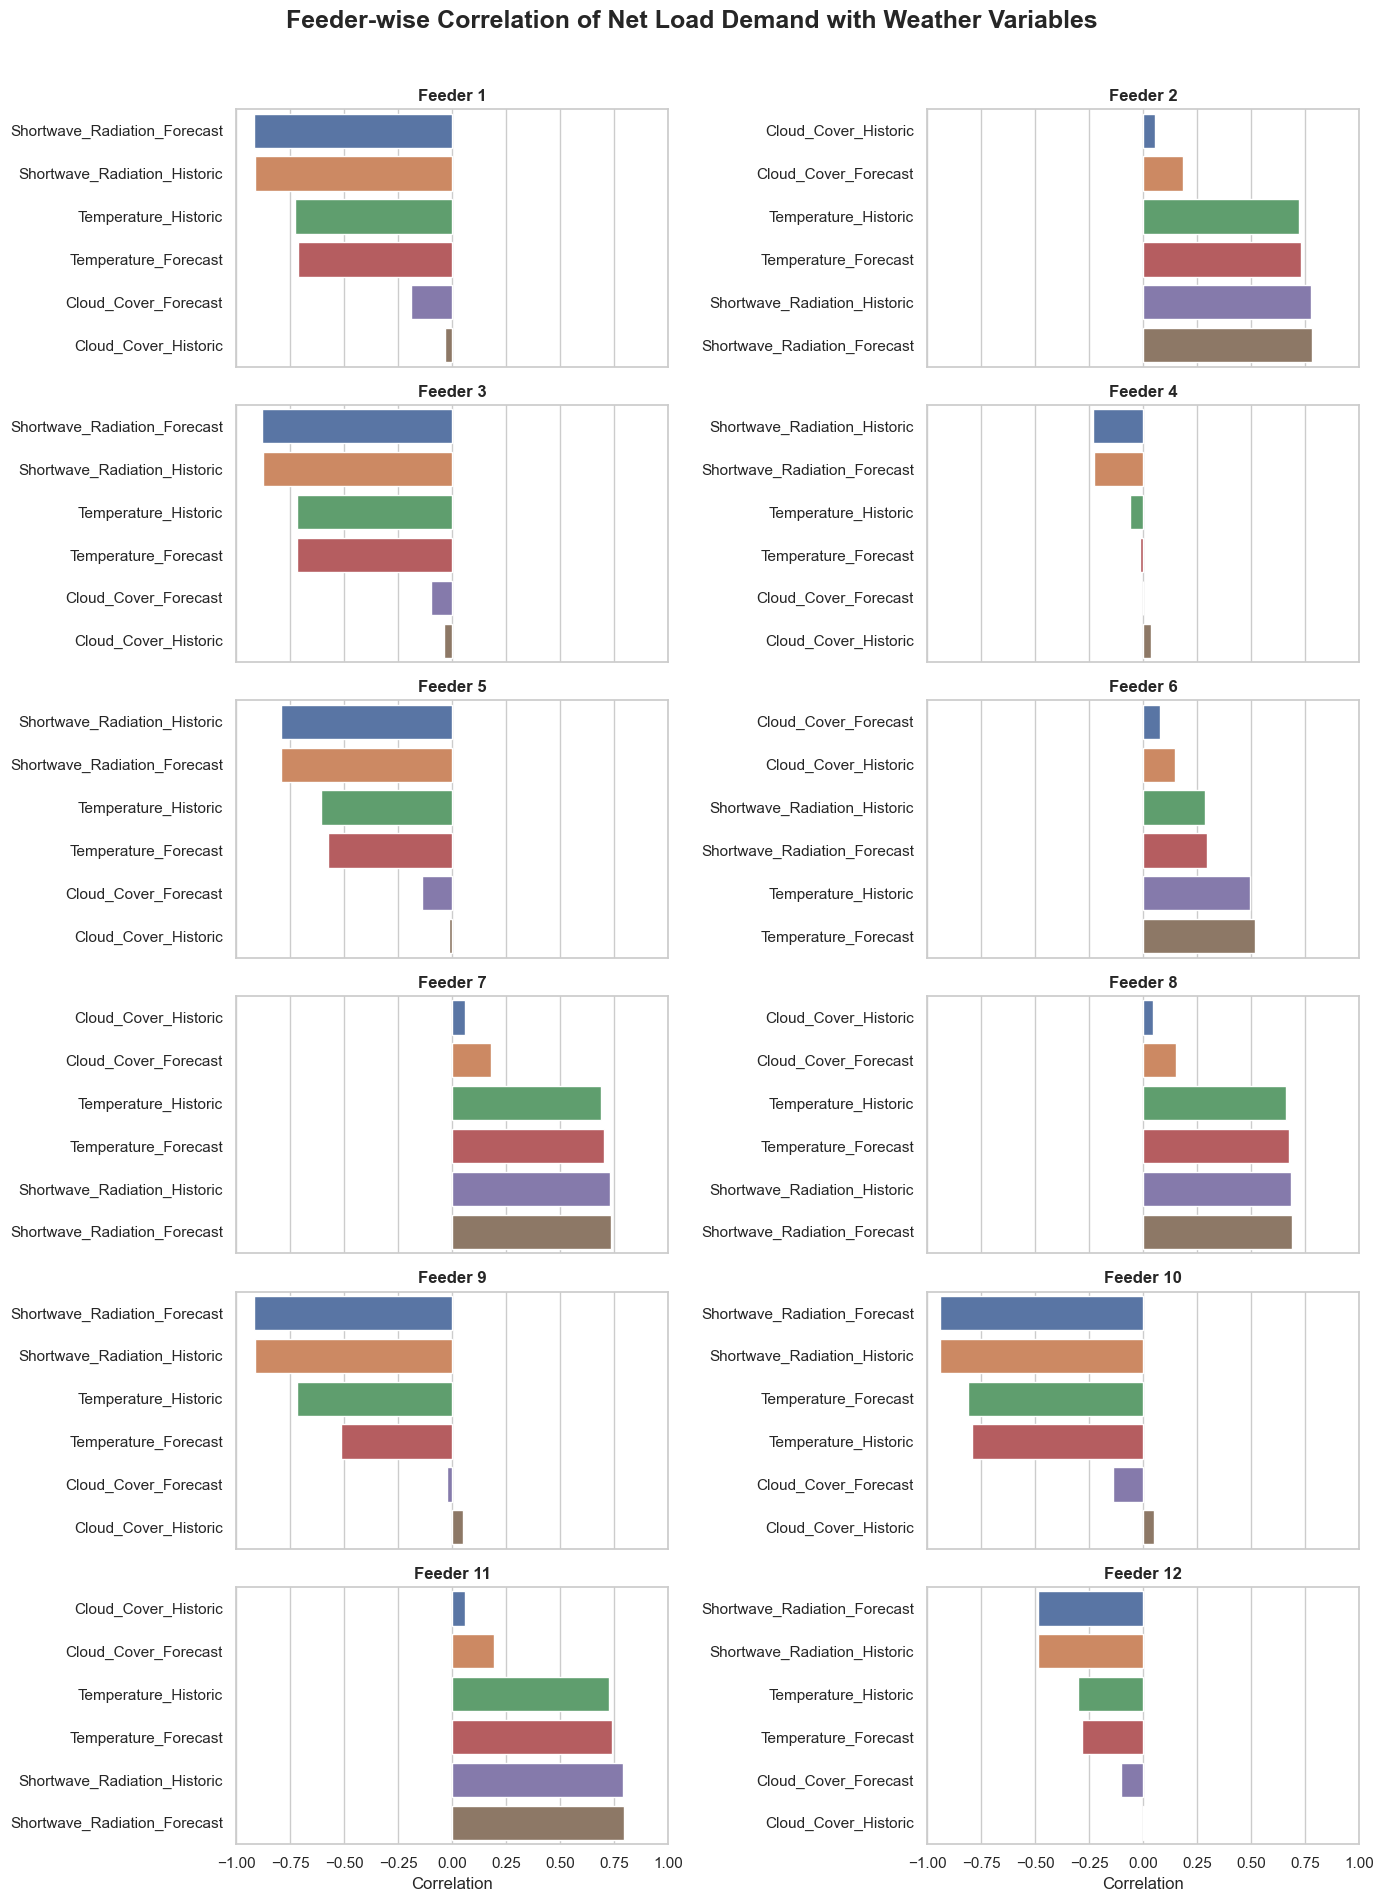

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming corr_df has columns: Feeder_ID, Variable, Correlation

# Set style for academic visual
sns.set(style="whitegrid")

# Define figure and axes
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 20), sharex=True)
fig.suptitle("Feeder-wise Correlation of Net Load Demand with Weather Variables", fontsize=18, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# List of feeder IDs sorted
feeder_ids = sorted(corr_df['Feeder_ID'].unique())

# Loop through each feeder
for idx, feeder in enumerate(feeder_ids):
    ax = axes[idx]
    feeder_data = corr_df[corr_df['Feeder_ID'] == feeder].sort_values('Correlation')
    
    # Horizontal barplot
    sns.barplot(
        x='Correlation',
        y='Variable',
        data=feeder_data,
        ax=ax,
        hue='Variable',
        palette='deep'
    )
    
    ax.set_title(f"Feeder {feeder}", fontsize=12, fontweight='bold')
    ax.set_xlim(-1, 1)
    ax.set_xlabel("Correlation" if idx >= 10 else "")  # show xlabel only for bottom rows
    ax.set_ylabel("")  # hide y-label; variable names will do

# Remove empty axes if any
for i in range(len(feeder_ids), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [30]:
corr_df

,Feeder_ID,Variable,Correlation
0,1,Temperature_Historic,-0.727921
1,1,Temperature_Forecast,-0.715123
2,1,Shortwave_Radiation_Historic,-0.913664
3,1,Shortwave_Radiation_Forecast,-0.917288
4,1,Cloud_Cover_Historic,-0.034963
...,...,...,...
67,12,Temperature_Forecast,-0.280535
68,12,Shortwave_Radiation_Historic,-0.487082
69,12,Shortwave_Radiation_Forecast,-0.487264
70,12,Cloud_Cover_Historic,0.004178
